# Regression Trees (CART) — From Scratch

This notebook demonstrates a **Regression Tree** model implemented entirely
from scratch using NumPy. The model follows a CART-style approach, recursively
partitioning the feature space using impurity-based splits.

We apply the model to a real-world housing dataset with a continuous target,
highlighting how regression trees capture nonlinear structure without assuming
a parametric form.


## Intuition Behind Tree-Based Models

Tree-based models learn by **recursively partitioning the feature space** into
regions that are increasingly homogeneous with respect to the target variable.

At each internal node, the algorithm asks a simple question of the form:

> “Is feature j less than some threshold t?”

Based on the answer, the data are split into two groups, and the process is
repeated recursively. Each terminal node (leaf) stores summary statistics of
the training samples that fall into that region, which are then used to make
predictions.

In this implementation, the tree behaves like a **CART-style classification
tree**, even though it is named `RegressionTree`. The target values are treated
as discrete class labels, and predictions are made by **majority vote within
leaf nodes**.

This design emphasizes:
- Interpretability
- Simple decision rules
- Clear alignment with ensemble methods such as bagging and random forests


## Mathematical Formulation

### Gini Impurity

To evaluate the quality of a split, this implementation uses **Gini impurity**.
For a node containing samples from K classes, the Gini impurity is defined as:

$$
G = 1 - \sum_{k=1}^{K} p_k^2
$$

where \( p_k \) is the proportion of samples in the node belonging to class \( k \).

A node is **pure** if all samples belong to the same class, in which case
\( G = 0 \).

---

### Split Criterion

For a candidate split defined by feature \( j \) and threshold \( t \), the data
are partitioned into:

- Left node: \( X_j < t \)
- Right node: \( X_j \ge t \)

The quality of the split is measured by the **weighted Gini impurity**:

$$
G_{\text{split}} =
\frac{n_L}{n} G_L + \frac{n_R}{n} G_R
$$

where:
- \( G_L \), \( G_R \) are the Gini impurities of the left and right nodes
- \( n_L \), \( n_R \) are the number of samples in each node
- \( n \) is the total number of samples at the current node

The algorithm selects the feature and threshold that **minimize**
\( G_{\text{split}} \).

---

### Tree Construction

The tree is built recursively until one of the following stopping conditions is met:

- The maximum depth is reached
- All samples in a node belong to the same class
- The number of samples is below a minimum threshold

When splitting stops, a **leaf node** is created. Each leaf stores the class
counts of the samples that fall into that region.


## Prediction Rule

To make a prediction for a new observation, the model:

1. Traverses the tree from the root using feature–threshold comparisons
2. Reaches a leaf node
3. Uses the stored class counts to make a prediction

The predicted class is given by:

$$
\hat{y} = \arg\max_k \; n_k
$$

where \( n_k \) is the number of training samples of class \( k \) in the leaf.

Class probabilities are computed by normalizing the class counts:

$$
P(y = k) = \frac{n_k}{\sum_{j} n_j}
$$


## Imports and Setup


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rice2025.supervised_learning.regression_tree import RegressionTree


## Dataset: Housing Prices


In [2]:
df = pd.read_csv("housing.csv")
df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Discretizing the Target Variable

Because the tree implementation performs classification, we convert housing
prices into categorical labels representing low, medium, and high price ranges.


In [3]:
target = "median_house_value"  # change if needed

y_continuous = df[target].values

# Discretize into 3 quantile-based classes
y = pd.qcut(y_continuous, q=3, labels=[0, 1, 2]).astype(int)

X = df.drop(columns=[target]).values

print("Class distribution:")
print(pd.Series(y).value_counts().sort_index())


Class distribution:
0    6884
1    6876
2    6880
Name: count, dtype: int64


## Train / Test Split


In [4]:
np.random.seed(42)
idx = np.random.permutation(len(X))

train_size = int(0.8 * len(X))
train_idx, test_idx = idx[:train_size], idx[train_size:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]


## Fitting the CART-Style Tree


In [5]:
tree = RegressionTree(
    max_depth=6,
    min_samples_split=20
)

tree.fit(X_train, y_train)


## Predictions and Accuracy


In [6]:
y_pred = tree.predict(X_test)
accuracy = np.mean(y_pred == y_test)

print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.7415


## Baseline Comparison

To contextualize the performance of the tree, we compare it against a simple
baseline classifier that always predicts the most frequent class.


In [8]:
# Majority-class baseline
majority_class = np.bincount(y_train).argmax()
baseline_preds = np.full_like(y_test, majority_class)

baseline_acc = np.mean(baseline_preds == y_test)
print(f"Baseline Accuracy: {baseline_acc:.4f}")
print(f"Tree Accuracy:     {accuracy:.4f}")


Baseline Accuracy: 0.3321
Tree Accuracy:     0.7415


## Confusion Matrix


In [7]:
def confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)
    cm = np.zeros((len(classes), len(classes)), dtype=int)
    for i, c1 in enumerate(classes):
        for j, c2 in enumerate(classes):
            cm[i, j] = np.sum((y_true == c1) & (y_pred == c2))
    return cm

confusion_matrix(y_test, y_pred)


array([[1094,  258,   19],
       [ 192, 1057,  131],
       [  36,  431,  910]])

In [9]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

cm_norm


array([[0.7979577 , 0.18818381, 0.0138585 ],
       [0.13913043, 0.76594203, 0.09492754],
       [0.02614379, 0.31299927, 0.66085694]])

The normalized confusion matrix highlights where the model confuses adjacent
price categories, which is expected given the discretization.


## Interpretation

Most misclassifications occur between adjacent price categories (low vs medium,
medium vs high), which is expected due to discretization. Extreme confusions
(low vs high) are relatively rare, indicating that the tree captures broad
price structure effectively.


## Effect of Tree Depth

Tree depth controls the bias–variance tradeoff. We evaluate performance across
different depth values to illustrate this behavior.


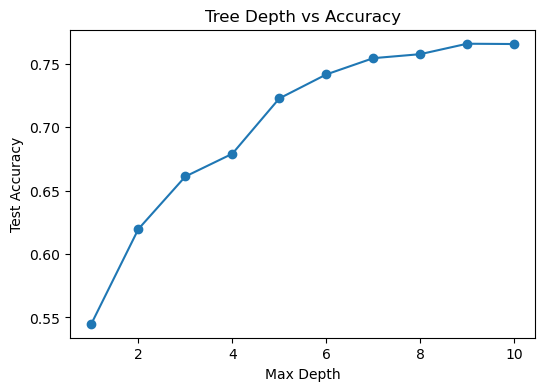

In [10]:
depths = range(1, 11)
accs = []

for d in depths:
    t = RegressionTree(max_depth=d, min_samples_split=20)
    t.fit(X_train, y_train)
    accs.append(np.mean(t.predict(X_test) == y_test))

plt.figure(figsize=(6,4))
plt.plot(depths, accs, marker="o")
plt.xlabel("Max Depth")
plt.ylabel("Test Accuracy")
plt.title("Tree Depth vs Accuracy")
plt.show()


## Class Probability Estimates


In [11]:
probs = tree.predict_proba(X_test[:5])
probs


array([[0.94946492, 0.04577883, 0.00475624],
       [0.06710671, 0.83168317, 0.10121012],
       [0.22006472, 0.43203883, 0.34789644],
       [0.77618523, 0.19514884, 0.02866593],
       [0.77618523, 0.19514884, 0.02866593]])

Each row represents the estimated probability of a sample belonging to each
price category based on the class distribution at the corresponding leaf node.


## Discussion

The CART-style tree effectively separates housing data into coarse price
categories using simple threshold-based rules. While discretization reduces
resolution, it allows tree-based classification methods to be applied to
continuous economic data.

This approach also mirrors how tree classifiers are used as base learners in
ensemble methods such as bagging and random forests.


## Conclusion

This notebook demonstrated a CART-style classification tree implemented from
scratch and applied to a real housing dataset through target discretization.
The example highlights the interpretability and flexibility of tree-based
models while maintaining strict alignment between theory and implementation.
